In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython import display
import time

In [2]:
root_path = r"D:\gans\datasets\cityscape_pair_dataset"
train_path = root_path+"\\train"
val_path = root_path+"\\val"

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 400
BATCH_SIZE = 1

In [4]:
def load_img(image_file):

    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    
    return input_image,real_image

In [5]:


i = 0
img,seg = load_img(r"D:\gans\datasets\cityscape_pair_dataset\val\img_0.png")


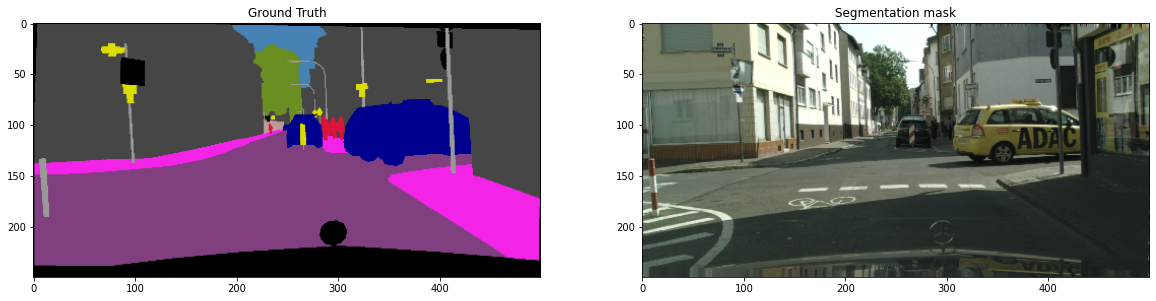

In [6]:
fig = plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img/255.0)
plt.title("Ground Truth")
plt.subplot(1,2,2)
plt.imshow(seg/255.0)
plt.title("Segmentation mask")
plt.show()

In [7]:
def resize_img(input_img,real_img, height,width):
    
    input_image = tf.image.resize(input_img, [height,width],
                                  method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    real_image = tf.image.resize(real_img, [height,width],
                                  method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

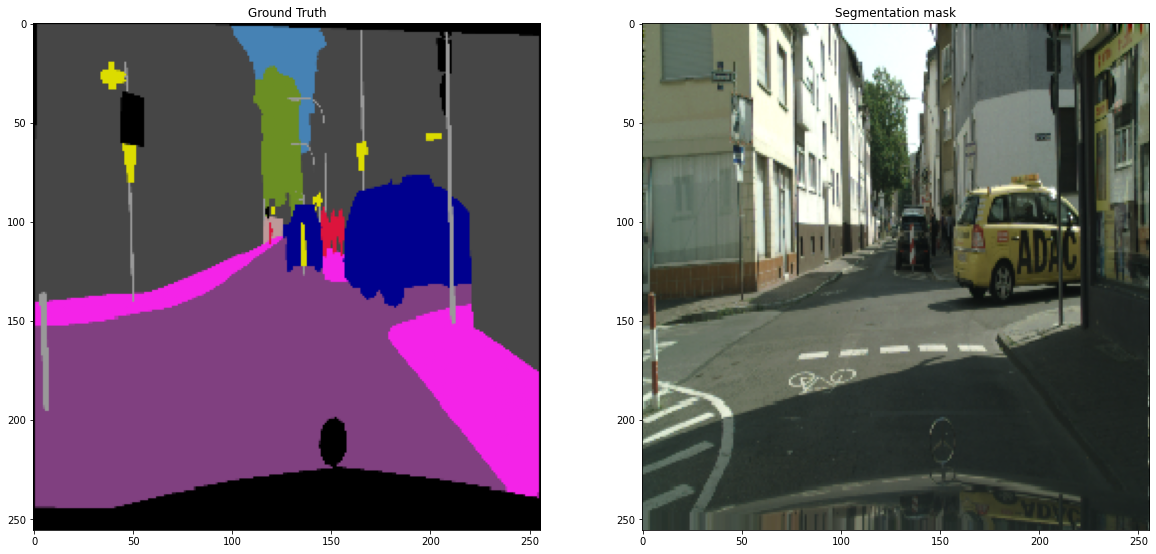

In [8]:

input_image, real_image = resize_img(img,seg, IMG_HEIGHT,IMG_WIDTH)
fig = plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(input_image/255.0)
plt.title("Ground Truth")
plt.subplot(1,2,2)
plt.imshow(real_image/255.0)
plt.title("Segmentation mask")
plt.show()

In [9]:
def random_crop(input_img,real_img):
    stacked_img = tf.stack([input_img,real_img],axis=0)
    cropped_img = tf.image.random_crop(
        stacked_img, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_img[0],cropped_img[1]

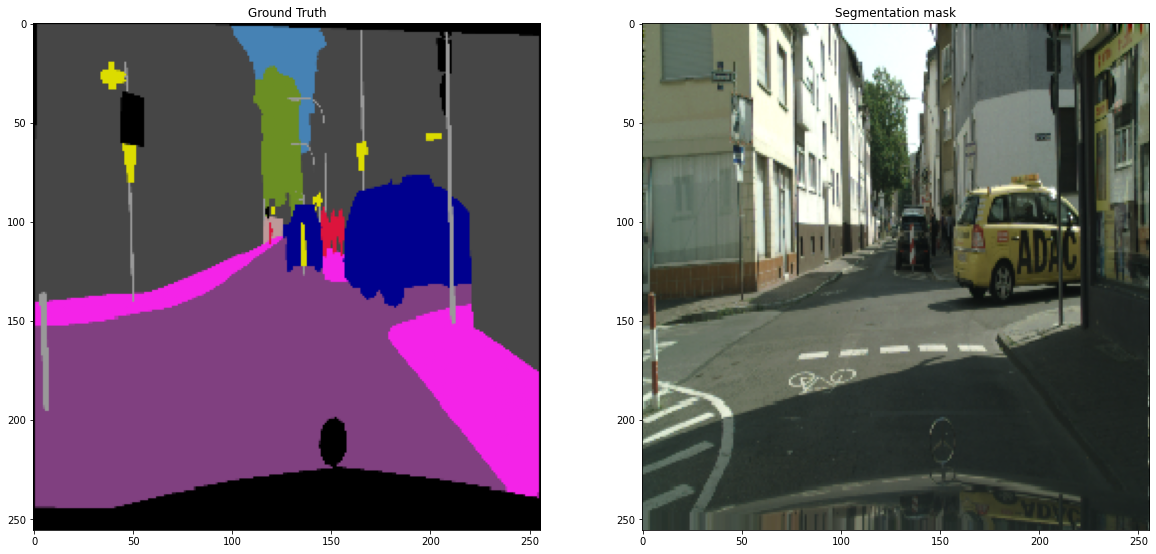

In [10]:
corp_input,crop_seg = random_crop(input_image,real_image)
fig = plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(corp_input/255.0)
plt.title("Ground Truth")
plt.subplot(1,2,2)
plt.imshow(crop_seg/255.0)
plt.title("Segmentation mask")
plt.show()

In [11]:
def normalize(input_img, real_img):
    input_image = (input_img/127.5)-1
    real_image = (real_img/127.5)-1
    
    return input_image,real_image

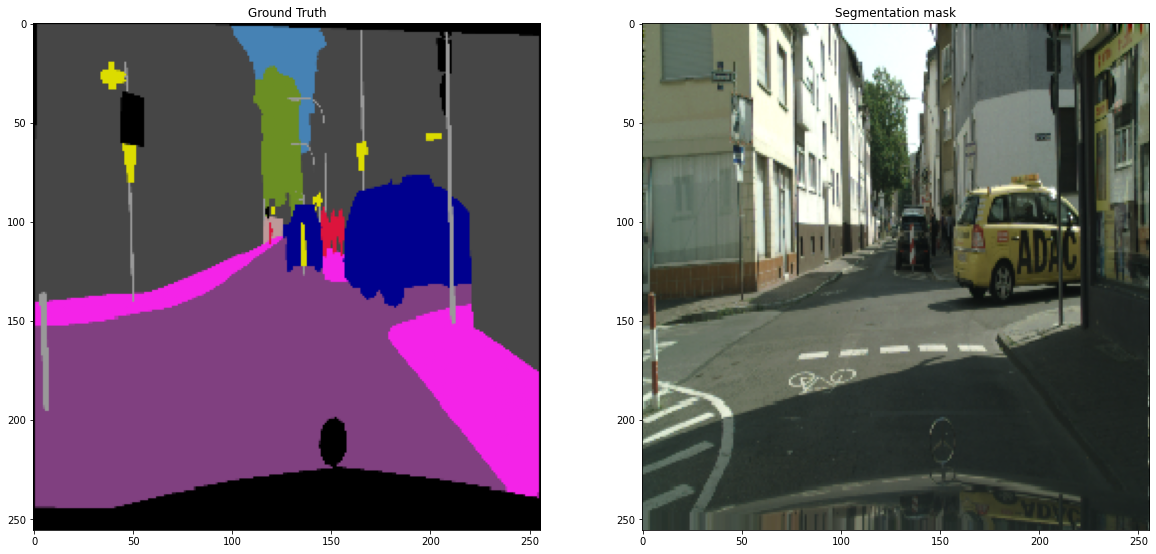

In [12]:
normalize_input,normalize_seg = random_crop(corp_input,crop_seg)
fig = plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(corp_input/255.0)
plt.title("Ground Truth")
plt.subplot(1,2,2)
plt.imshow(crop_seg/255.0)
plt.title("Segmentation mask")
plt.show()

In [13]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.75554514>

In [14]:
@tf.function()
def random_jitter(input_img,real_img):
    
    #resize image
    input_image,real_image = resize_img(input_img,real_img,IMG_HEIGHT,IMG_WIDTH)
    
    #random cropping
    input_image,real_image = random_crop(input_image,real_image)
    
    if tf.random.uniform(()) > 0.5:
        
        #random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image, real_image

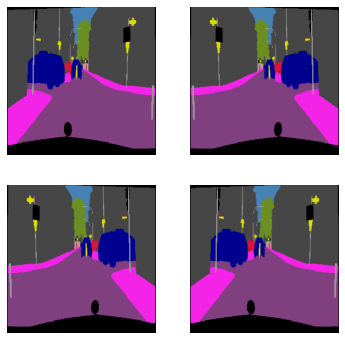

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(img,seg)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [16]:
def load_image_train(image_file):
    input_image,real_image = load_img(image_file)
    input_image,real_image = resize_img(input_image,real_image,IMG_HEIGHT,IMG_WIDTH)
    input_image,real_image = random_jitter(input_image,real_image)
    input_image,real_image = normalize(input_image,real_image)
    
    return input_image,real_image

In [17]:
def load_image_test(image_file):
    input_image,real_image = load_img(image_file)
    input_image,real_image = resize_img(input_image,real_image,IMG_HEIGHT,IMG_WIDTH)
    input_image,real_image = normalize(input_image,real_image)
    
    return input_image,real_image

In [18]:
#Input PipeLine
PATH = r"D:\gans\datasets\cityscape_pair_dataset\train\*.png" 
train_dataset = tf.data.Dataset.list_files(PATH)
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
PATH = r"D:\gans\datasets\cityscape_pair_dataset\val\*.png"
test_dataset = tf.data.Dataset.list_files(PATH)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [20]:
def downsample(filters,size,apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2D(filters,size,strides = 2, padding='same',
                                     kernel_initializer = initializer,use_bias =False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    
    return result

In [21]:
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(normalize_input,0))
print(down_result.shape)

(1, 128, 128, 3)


In [22]:
def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding = 'same',
                                              kernel_initializer = initializer, use_bias = False)
              )
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

In [23]:
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [24]:
OUTPUT_CHANNELS = 3

In [25]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3]) # (bs, 256,256, 3)
    
    down_stack = [
        downsample( 64, 4, apply_batchnorm = False), # (bs, 128,128, 64)
        downsample(128,4),  # (bs, 64, 64, 128)
        downsample(256,4),  # (bs, 32, 32, 256)
        downsample(512,4),  # (bs, 16, 16, 512)
        downsample(512,4),  # (bs, 8, 8, 512)
        downsample(512,4),  # (bs, 4, 4, 512)
        downsample(512,4),  # (bs, 2, 2, 512)
        downsample(512,4),  # (bs, 1, 1, 512)
        
    ]
    
    
    up_stack = [
        upsample(512,4, apply_dropout = True), # (bs, 2,2, 1024)
        upsample(512,4, apply_dropout = True), # (bs, 4,4, 1024)
        upsample(512,4, apply_dropout = True), # (bs, 8,8, 1024)
        upsample(512,4), # (bs, 16,16, 1024)
        upsample(256,4), # (bs, 32, 32, 512)
        upsample(128,4), # (bs,64, 64, 256)
        upsample(64,4),  # (bs, 128, 128, 128)
    ]
    
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides = 2,
                                          padding = 'same',
                                          kernel_initializer = initializer,
                                          activation = 'tanh') #(bs, 256,256, 3)
    
    x = inputs
    
    
    #Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    #Upsampling and establishing the skip connections
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs,outputs= x)

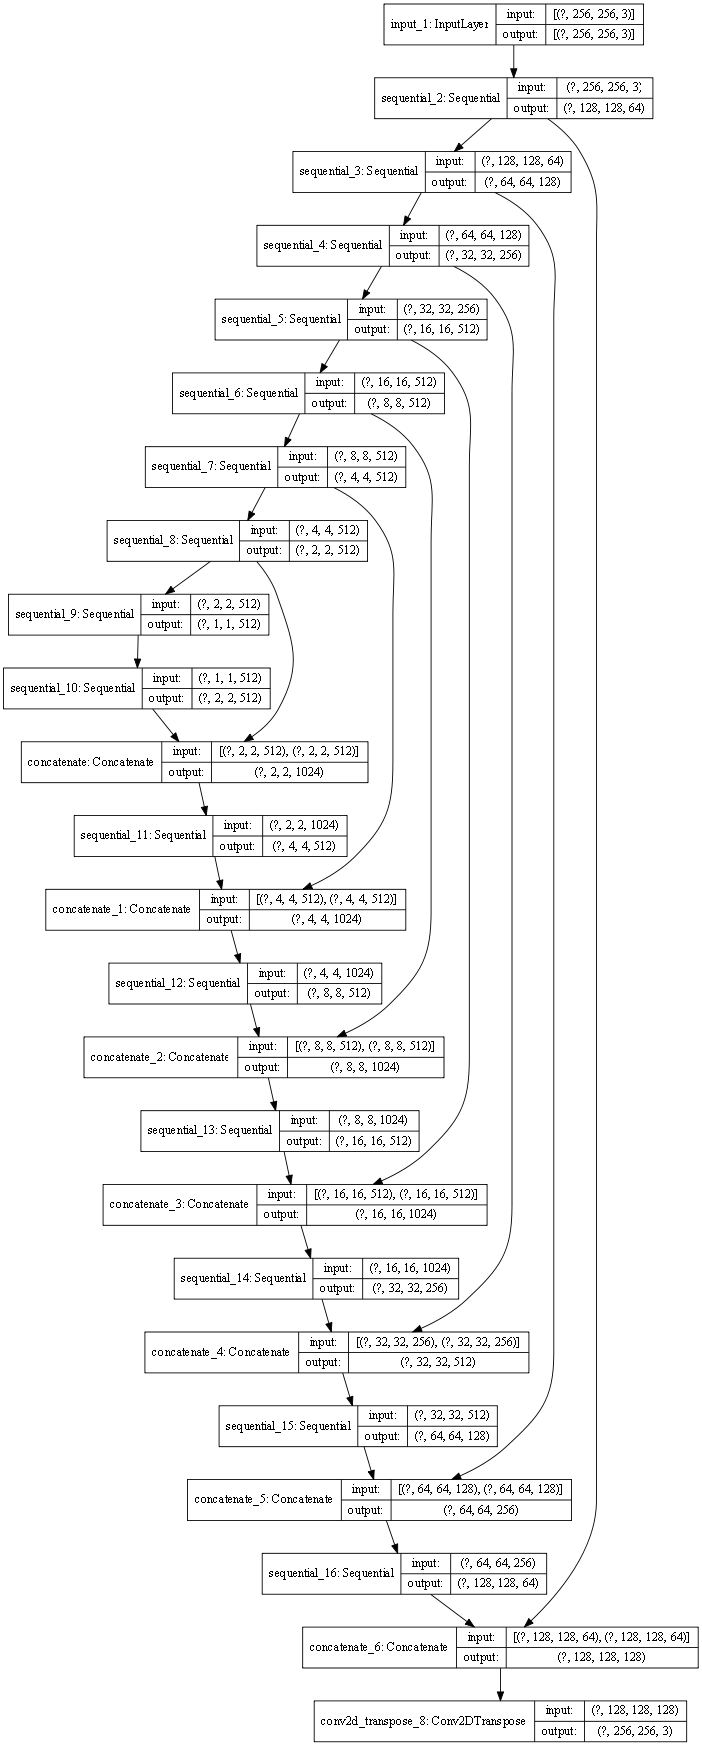

In [26]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


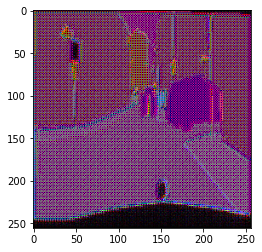

In [27]:
gen_output = generator(normalize_input[tf.newaxis,...], training = False)
plt.imshow(gen_output[0,...])

In [28]:
loss_object =  tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [29]:
#Generator loss
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gen_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    #mae loss
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gen_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gen_loss,l1_loss

In [30]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape = [256,256,3], name = 'input_image')
    tar = tf.keras.layers.Input(shape = [256,256,3], name = 'target_image')
    
    x = tf.keras.layers.concatenate([inp,tar]) # (bs, 256,256, channels*2)
    
    down1 = downsample(64,4, False)(x)  # (bs, 128,128,64)
    down2 = downsample(128,4)(down1)    # (bs, 64,64, 128)
    down3 = downsample(256,4)(down2)    # (bs, 32,32,256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34,34, 256)
    
    conv = tf.keras.layers.Conv2D(512, 4, strides = 1,
                                 kernel_initializer = initializer,
                                 use_bias = False)(zero_pad1) #(bs,31,31,512)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) #(bs, 33,33,512)
    
    
    last = tf.keras.layers.Conv2D(1,4, strides=1,
                                 kernel_initializer = initializer)(zero_pad2)# (bs, 30, 30, 1)
    
    
    return tf.keras.Model(inputs = [inp,tar],outputs= last)

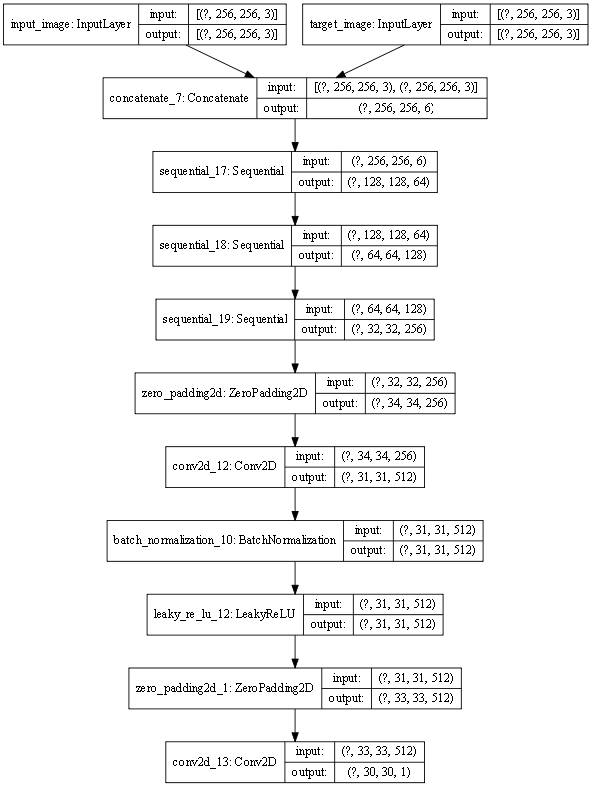

In [31]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

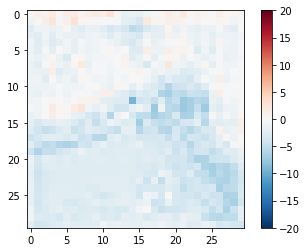

In [32]:
disc_out = discriminator([normalize_input[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [33]:
def discriminator_loss(disc_real_output,disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    
    return total_disc_loss

In [34]:
generator_optimizer =  tf.keras.optimizers.Adam(2e-4,beta_1= 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)


In [35]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [36]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

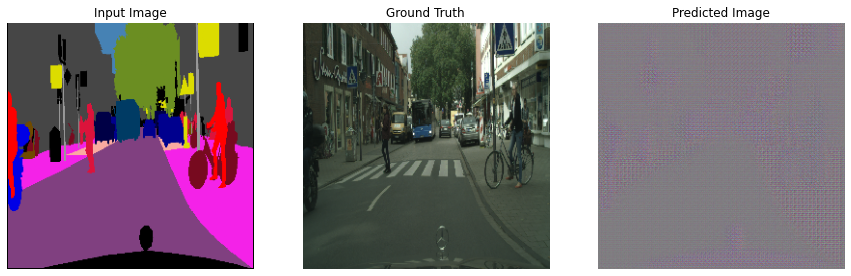

In [37]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [38]:
EPOCHS = 150

import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [39]:
@tf.function
def train_step(input_image,target,epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image,training = True)
        
        disc_real_output = discriminator([input_image,target],training = True)
        disc_generated_output = discriminator([input_image,gen_output], training=True)
        
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,gen_output,target)
        
        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)
        
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)
        
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)
        
        
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                   discriminator.trainable_variables))
        
        
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [40]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait = True)
        
        
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        
        print("Epoch :",epoch)
        for n,(input_image,target) in train_ds.enumerate():
            print(".",end='')
            if (n+1)%100 ==0:
                print()
            train_step(input_image,target,epoch)
        print()
        
    

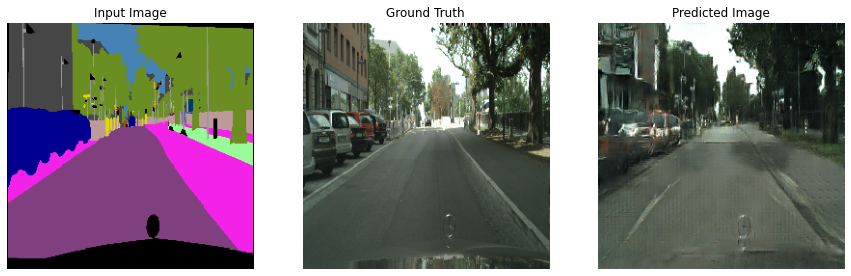

Epoch : 24
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)